# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import logging
%matplotlib inline  

# Initializing the logging format

In [2]:
LOG_FORMAT = "%(asctime)s %(filename)s:%(lineno)d %(message)s"
logging.basicConfig(filename='cvd_training.log', level=logging.DEBUG, format=LOG_FORMAT)

# Importing the dataset

In [3]:
df = pd.read_csv("cardio_train.csv",engine="python",delimiter=";")

# Plotting a heatmap for the dataset using seaborn

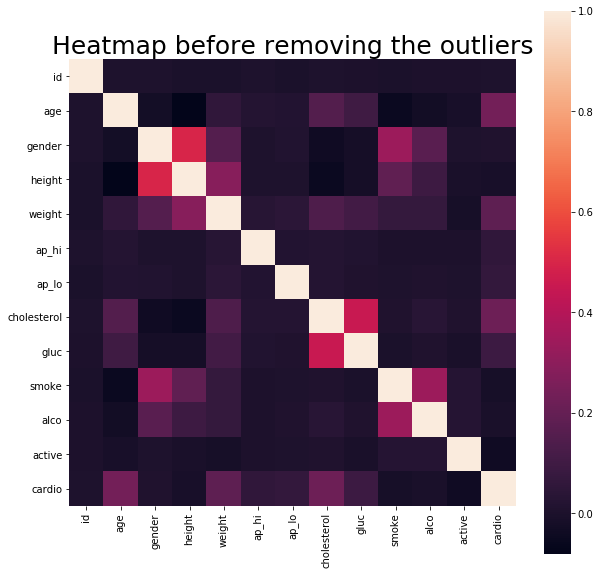

In [4]:
bcorr = df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(bcorr, square=True)
ax.set_title('Heatmap before removing the outliers',fontsize =25)
plt.show()

# Basic information about the dataset using the info() and describe() methods

In [5]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
id             69301 non-null int64
age            69301 non-null int64
gender         69301 non-null int64
height         69301 non-null int64
weight         69301 non-null float64
ap_hi          69301 non-null int64
ap_lo          69301 non-null int64
cholesterol    69301 non-null int64
gluc           69301 non-null int64
smoke          69301 non-null int64
alco           69301 non-null int64
active         69301 non-null int64
cardio         69301 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


(None,
                  id           age        gender        height        weight  \
 count  69301.000000  69301.000000  69301.000000  69301.000000  69301.000000   
 mean   50471.480397  19468.786280      1.349519    164.362217     74.203027   
 std    28563.100347   2467.261818      0.476821      8.205337     14.383469   
 min      988.000000  10798.000000      1.000000     55.000000     10.000000   
 25%    25745.000000  17664.000000      1.000000    159.000000     65.000000   
 50%    50494.000000  19704.000000      1.000000    165.000000     72.000000   
 75%    75150.000000  21326.000000      2.000000    170.000000     82.000000   
 max    99999.000000  23713.000000      2.000000    250.000000    200.000000   
 
               ap_hi         ap_lo   cholesterol          gluc         smoke  \
 count  69301.000000  69301.000000  69301.000000  69301.000000  69301.000000   
 mean     128.829584     96.650092      1.366806      1.226447      0.088051   
 std      154.775805    189.096

# Removing the "ID" column beacuse it serves no purpose in model training and converting the feature "AGE" from days to years by dividing the entire column by 365

In [6]:
df = df.drop('id',axis=1)
df['age'] = df['age'].apply(lambda x: int(x/365))
df = df.rename(columns={"ap_hi": "systolic_bp", "ap_lo": "diastolic_bp"})

# Removing outliers from the columns: age, height, weight, systolic bp and diastolic bp

In [7]:
# 25th percentile 
q25 = np.percentile(df['age'], 25)
# 75th percentile
q75 = np.percentile(df['age'], 75)
# Cut off
cut_off = (q75 - q25)*1.5
# Lower cut off calculated
lower_quart = q25 - cut_off
# Upper cut off calculated
upper_quart = q75 + cut_off
# Dataframe filtered using the cut-off levels
df_age = df[(df['age'] < upper_quart) & (df['age'] > lower_quart)]


q25 = np.percentile(df_age['weight'], 25)
q75 = np.percentile(df_age['weight'], 75)
cut_off = (q75 - q25)*1.5
lower_quart = q25 - cut_off
upper_quart = q75 + cut_off
df_weight = df_age[(df_age['weight'] < upper_quart) & (df_age['weight'] > lower_quart)]

q25 = np.percentile(df_weight['height'], 25)
q75 = np.percentile(df_weight['height'], 75)
cut_off = (q75 - q25)*1.5
lower_quart = q25 - cut_off
upper_quart = q75 + cut_off
df_height = df_weight[(df_weight['height'] < upper_quart) & (df_weight['height'] > lower_quart)]

q25 = np.percentile(df_height['systolic_bp'], 25)
q75 = np.percentile(df_height['systolic_bp'], 75)
cut_off = (q75 - q25)*1.5
lower_quart = q25 - cut_off
upper_quart = q75 + cut_off
df_sys = df_height[(df_height['systolic_bp'] < upper_quart) & (df_height['systolic_bp'] > lower_quart)]

q25 = np.percentile(df_sys['diastolic_bp'], 25)
q75 = np.percentile(df_sys['diastolic_bp'], 75)
cut_off = (q75 - q25)*1.5
lower_quart = q25 - cut_off
upper_quart = q75 + cut_off
df = df_sys[(df_sys['diastolic_bp'] < upper_quart) & (df_sys['diastolic_bp'] > lower_quart)]

# The feature "gender" is considered to be categorical so i performed the get_dummies operation over it and dropped the columns which may create multi-collinearity

In [8]:
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gender')],axis=1).drop(['gender','gender_2'],axis=1)

# Plotting a heatmap for the dataset using seaborn after removing the outliers


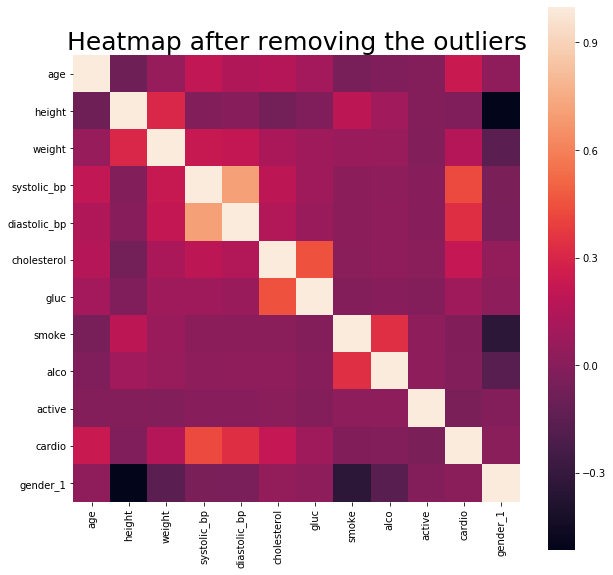

In [9]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, square=True)
ax.set_title('Heatmap after removing the outliers',fontsize =25)
plt.show()

# Frequency plots

Text(0.5, 1.0, 'Age distribution')

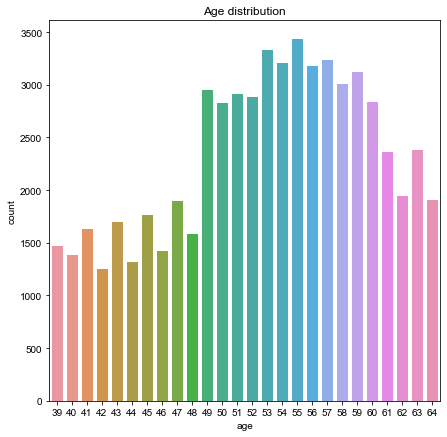

In [10]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="age", data=df).set_title("Age distribution")

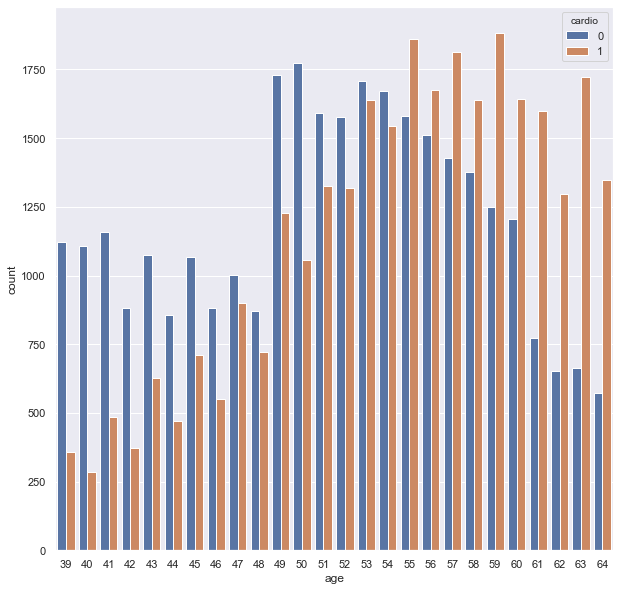

In [36]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax =sns.countplot(x='age', hue='cardio', data = df);

Text(0.5, 1.0, 'Glucose values distribution')

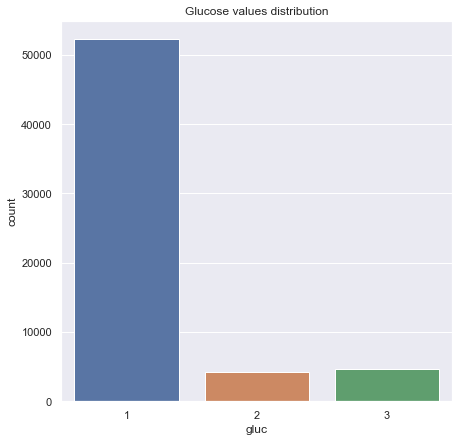

In [12]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="gluc", data=df).set_title("Glucose values distribution")

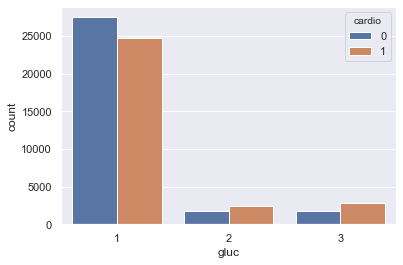

In [13]:
ax =sns.countplot(x='gluc', hue='cardio', data = df)

Text(0.5, 1.0, 'Cholesterol values distribution')

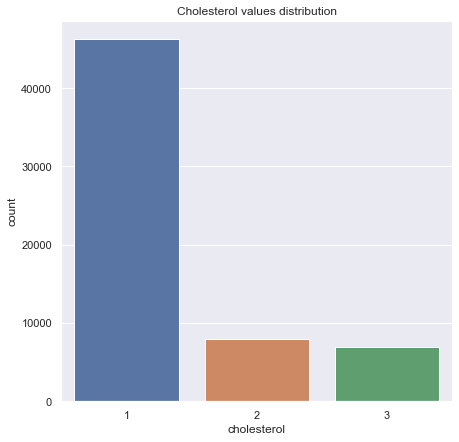

In [14]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="cholesterol", data=df).set_title("Cholesterol values distribution")

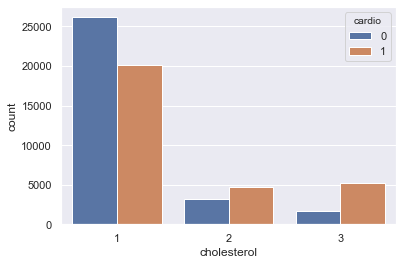

In [15]:
ax =sns.countplot(x='cholesterol', hue='cardio', data = df)

Text(0.5, 1.0, 'Physically active Countplot')

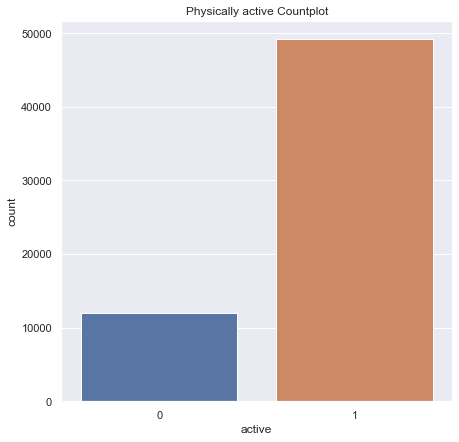

In [16]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="active", data=df).set_title("Physically active Countplot")

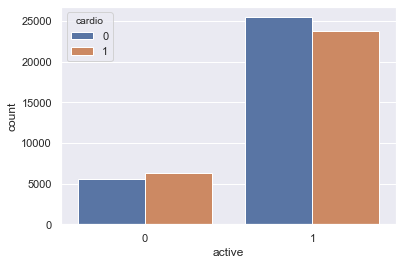

In [17]:
ax =sns.countplot(x='active', hue='cardio', data = df)

Text(0.5, 1.0, 'Alcohol consumption Countplot')

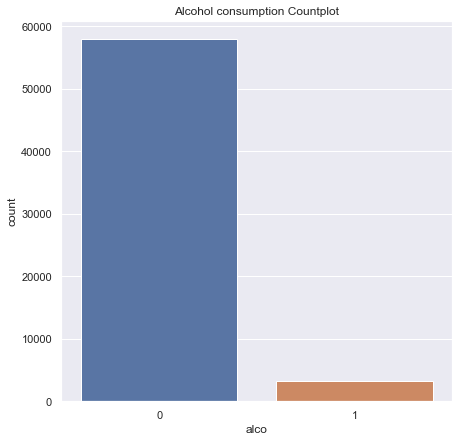

In [18]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="alco", data=df).set_title("Alcohol consumption Countplot")

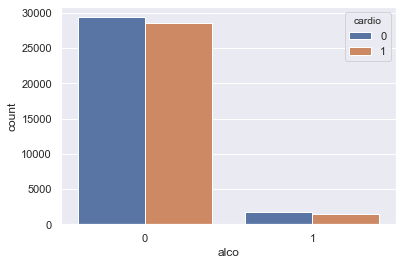

In [19]:
ax =sns.countplot(x='alco', hue='cardio', data = df)

Text(0.5, 1.0, 'Smoking Countplot')

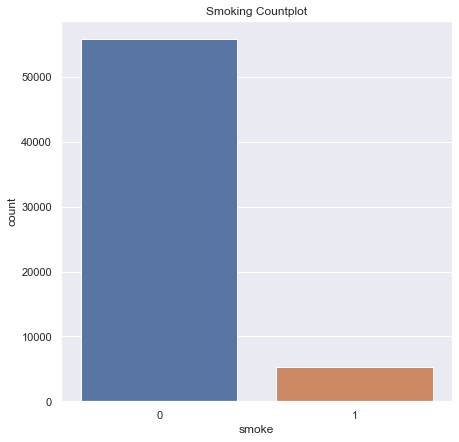

In [20]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="smoke", data=df).set_title("Smoking Countplot")

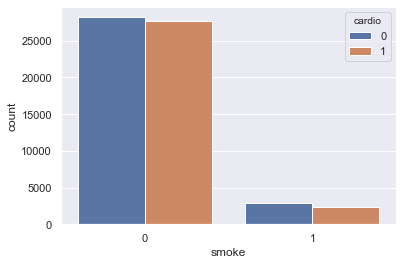

In [21]:
ax =sns.countplot(x='smoke', hue='cardio', data = df)

Text(0.5, 1.0, 'Cardio Countplot')

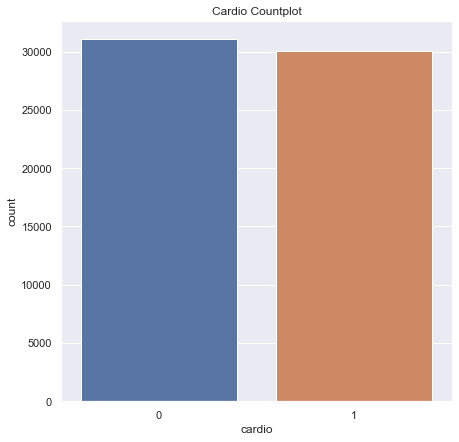

In [22]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.set(style="darkgrid")
sns.countplot(x="cardio", data=df).set_title("Cardio Countplot")

# Seperating the independent and dependent variables 

In [10]:
X = df.drop('cardio',axis=1)
y = df.cardio

# Splitting the dataset for training and testing

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Logistic regression

In [25]:
# Initializing the  model
logreg = LogisticRegression()

In [27]:
# Create regularization penalty space
penalty = ['l1','l2']

# Create regularization hyperparameter space
C = range(1,3)

# Solvers
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=1)

# Logging the training of the model
logging.info(clf.fit(X_train, y_train))

best_model = clf.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/siddhesh/anaconda3/lib/python3.7

/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/siddhesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

# Logging the best parameters of the model

In [28]:
logging.debug("Best model:-{}".format(best_model))
logging.debug("Best penalty:-{}".format(best_model.get_params()['penalty']))
logging.debug("Best C:-{}".format(best_model.get_params()['C']))
logging.debug("Best Solver:-{}".format(best_model.get_params()['solver']))

# Viewing the best hyperparameters

In [29]:
print('Best Penalty:', best_model.get_params()['penalty'])
print('Best C:', best_model.get_params()['C'])
print('Best solver:', best_model.get_params()['solver'])

Best Penalty: l2
Best C: 1
Best solver: liblinear


# Predicting the test-set  and viewing the accuracy of the model over the test set

In [30]:
logging.info(best_model.predict(X_test))
y_pred = best_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(best_model.score(X_test, y_test)))
logging.info('Accuracy of logistic regression classifier on test set: {:.2f}'.format(best_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


# Accuracy score


In [31]:
scores_classification = accuracy_score(y_test, y_pred)
scores_classification*100

72.04872465663833

# Printing the classification report


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6206
           1       0.75      0.65      0.70      6026

    accuracy                           0.72     12232
   macro avg       0.72      0.72      0.72     12232
weighted avg       0.72      0.72      0.72     12232



# Printing the confusion matrix


In [33]:
results = confusion_matrix(y_test, y_pred)
print(results)

[[4908 1298]
 [2121 3905]]


# Saving the model using pickle

In [ ]:
pickle.dump(best_model,open('cardio_2.pkl','wb'))

# Following are the other models i tried using, I am not going into the details with them because logistic regression was finalized.

# Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
y_pred = gnb.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import accuracy_score  

scores_classification = accuracy_score(y_test, y_pred)
scores_classification

# D-tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(criterion="mse")

params={
 "splitter"    : ["best","random"] ,
 "max_depth"        : [4],
 "min_samples_leaf" : [1,2],
"min_weight_fraction_leaf":[0.1,0.2,0.3],
 "max_features" : ["auto"],
    "max_leaf_nodes":[None]   
}

In [ ]:
from sklearn.model_selection import GridSearchCV

model=GridSearchCV(dtree,param_grid=params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)

In [ ]:
model.fit(X,y)

In [ ]:
model.best_params_,model.best_score_

In [ ]:
predictions=model.predict(X_test)
predictions = [1 if i >=0.5 else 0 for i in predictions]

In [ ]:
scores_classification = accuracy_score(y_test, predictions)
scores_classification

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# XGB

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, learning_rate=0.0001, n_estimators=100,
                       objective='binary:logistic')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Rough work

In [ ]:
<option value=3>SF Bay area</option>


In [ ]:
for i in range(0,200):
    print("<option value=1>"+str(i)+"</option>")

In [ ]:
df.to_excel("automl_exe.xlsx")

In [ ]:
df.describe()

In [ ]:
best_model = pickle.load(open("/Users/siddhesh/Desktop/git_cvd/cardio_2.pkl", 'rb'))


In [11]:
X

,age,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,gender_1
0,61,155,69.0,130,80,2,2,0,0,1,1
1,40,163,71.0,110,70,1,1,0,0,1,1
2,60,165,70.0,120,80,1,1,0,0,1,1
3,39,165,85.0,120,80,1,1,1,1,1,0
4,64,155,62.0,120,80,1,1,0,0,1,1
5,57,164,61.0,100,70,1,1,0,0,1,1
6,49,162,72.0,100,70,1,1,0,0,1,1
7,61,161,93.0,140,90,2,1,0,0,1,1
8,58,157,68.0,110,80,1,1,0,0,1,1
9,61,158,65.0,140,90,3,1,0,0,1,1
